# 신용카드 사기검출
- 데이터 다운로드 : https://www.kaggle.com/mlg-ulb/creditcardfraud
- 해당 데이터 셋의 레이블인 Class 속성은 매우 불균형한 분포
- 0은 정상 신용카드 트랜잭션, 1은 시용카드 사기 트랙잭션 의미를 의미
- 전체 데이터의 약 0.172%만이 레이블 값이 1, 즉 사기 트랜잭션
- 일반적으로 사기검출이나 이상 검출과 같은 데이터 셋은 이처럼 레이블 값이 극도로 불균형한 분포 가지기 쉬움

> **언더 샘플링과 오버 샘플링의 이해**
- 레이블이 불균형한 분포를 가진 데이터 셋 학습시, 이상 레이블을 가지는 데이터 건수가 매우 적어 제대로 된 유형의 학습이 어려움
- 반면 정상 레이블을 가지는 데이터 건수는 많아 일방적으로 정상 레이블로 치우친 학습을 수행하여, 제대로된 데이터 검출이 어려움
- 대표적으로 오버 샘플링(Oversampling)과 언더 샘플링(Undersampling) 방법을 통해 적절한 학습 데이터 확보

> **언더 샘플링**
- 많은 레이블을 가진 데이터 셋을 적은 레이블을 가진 데이터 셋 수준으로 감소
- 정상 레이블 데이터 건수 10,000건, 이상 레이블 데이터 건수 100건 있으면 정상 레이블 데이터를 100건으로 줄여 버리는 방식
- 줄여 버린 상태에서 학습 수행시 과도하게 정상 레이블로 학습/예측하는 부작용 개선
- 너무 많은 정상 레이블 데이터 감소시키기 때문에 정상 레이블의 경우 오히려 제대로 된 학습 수행할 수 없는 단점이 있어 잘 적용하지 않음

> **오버 샘플링**
- 적은 레이블을 가진 데이터 셋을 많은 레이블을 가진 데이터 셋 수준으로 증식
- 동일 데이터를 단순 증식하는 방법은 과적합 되므로 의미 없기 때문에, 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식
- 대표적으로 SMOTE(Synthetic Minority Over-sampling Technique) 방법
 - 적은 데이터 셋에 있는 개별 데이터들의 K 최근접 아웃(K Nearest Neighbor)을 찾아 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어 기존 데이터와 약간 차이나는 새로운 데이터 생성하는 방식

# 1. 데이터 일차 가공 및 모델 학습/예측/평가

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./CreditCard_FraudDetection/creditcard.csv')
# 데이터셋 형태 확인
print('dataset shape:',card_df.shape)

# 데이터셋 상위 3개 컬럼 확인
card_df.head(3)

dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


- Time 은 데이터 생성 관련한 작업용 속성으로 제거    
- V1~V28 은 kaggle 데이터 설명에서 사용자 ID 및 중요한 기능을 보호하기 위한 PCA 차원 감소의 결과 라고 되어있다. 즉, 피처의 의미를 알 수 없음  
- Amount 는 신용카드 트랜잭션의 금액을 의미  
- Class 는 0이면 정상, 1이면 사기 트랜잭션

In [2]:
# 데이터 피처 타입 확인
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Null 값은 존재하지 않으며, Class를 제외한 모든 피처의 데이터 타입은 float64형

**원본 DataFrame은 유지하고 데이터 가공을 위한 DataFrame을 복사하여 반환**

In [3]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

**학습과 테스트 데이터 셋을 반환하는 함수 생성. 사전 데이터 처리가 끝난 뒤 해당 함수 호출**

In [4]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    # 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 혼동행렬, 정확도, 정밀도, 재현율, F1 SCORE, AUC 불러오기
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

**LogisticRegression 학습/예측/평가**

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1: 0.7120, AUC:0.9568


**앞으로 피처 엔지니어링을 수행할 때마다 모델을 학습/예측/평가하므로 이를 위한 함수 생성** 

In [8]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 셋를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

**LightGBM 학습/예측/평가**

In [9]:
from lightgbm import LGBMClassifier

# (boost_from_average=True일때 레이블 값이 불균형 분포를 이루는 경우 재현률 및 ROC-AUC 성능이 매우 저하됨
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

# 입력받은 학습/테스트 데이터 셋을 통해 학습/예측/평가 수행
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC:0.9790


전체적으로 정밀도, 재현율, F1, AUC 값들이 로지스틱 회귀보다 높은 수치를 나타냄

# 2. 중요 데이터 분포도 변환 후 모델 학습/예측/평가

**중요 feature의 분포도 확인**

<AxesSubplot:xlabel='Amount', ylabel='Density'>

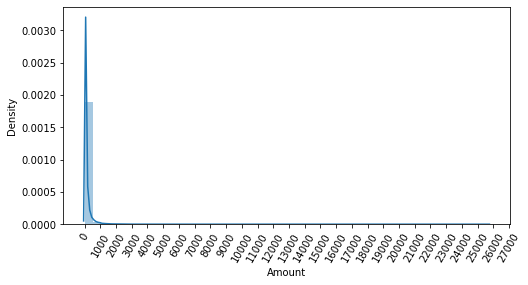

In [10]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)

# Amount 피처의 분포도 확인
sns.distplot(card_df['Amount'])

- Amount(카드 사용금액) 피처는 1000불 이하인 데이터가 대부분
- 27,000불까지 드물지만 많은 금액 사용 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선
- Amount 피처를 표준 정규 분포 형태로 변환 뒤 로지스틱 회귀의 예측 성능 측정
- StandardScaler : 데이터의 평균 0, 분산과 표준편차 1로 만들어주는 함수

**데이터 사전 가공을 위한 별도의 함수에 StandardScaler를 이용하여 Amount 피처 변환**

In [11]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

**StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가**

In [12]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, F1: 0.8409, AUC:0.9779


Amount 피처 값을 정규분포형태로 변환후 적용한 두 모델 모두 이전과 비교해서 성능 크게 개선되지 않음을 확인

**Amount를 로그 변환**

In [13]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    # log1p는 np.log()함수 대입시 -inf가 포함되므로 +1을 해줘서 -inf->0으로 변경
    # expm1는 반대로 exp(배열값)에 -1하여 np.log1값을 np.log값으로 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [14]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC:0.9796


- 로지스틱 회귀 모델의 경우 정밀도, ROC-AUC에서 약간씩 성능 개선
- LightGBMD 모델의 경우 정밀도, 재현율, ROC-AUC에서 약간씩 성능 개성

# 3. 이상치 데이터 제거 후 모델 학습/예측/평가

> **이상치 데이터(Outlier)란**
- 이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터
- 이상치로 인해 ML 모델의 성능에 영향을 받는 경우 발생하기 쉬움

> **이상치 탐색 방법**
- IQR(Inter Quantile Range) 방식
 - 사분위(Quantile)값의 편차를 이용하는 기법
 - 박스 플롯(Box Plot)방식으로 시각화 가능

**각 피처들의 상관 관계를 시각화. 결정 레이블인 class 값과 가장 상관도가 높은 피처 추출**

<AxesSubplot:>

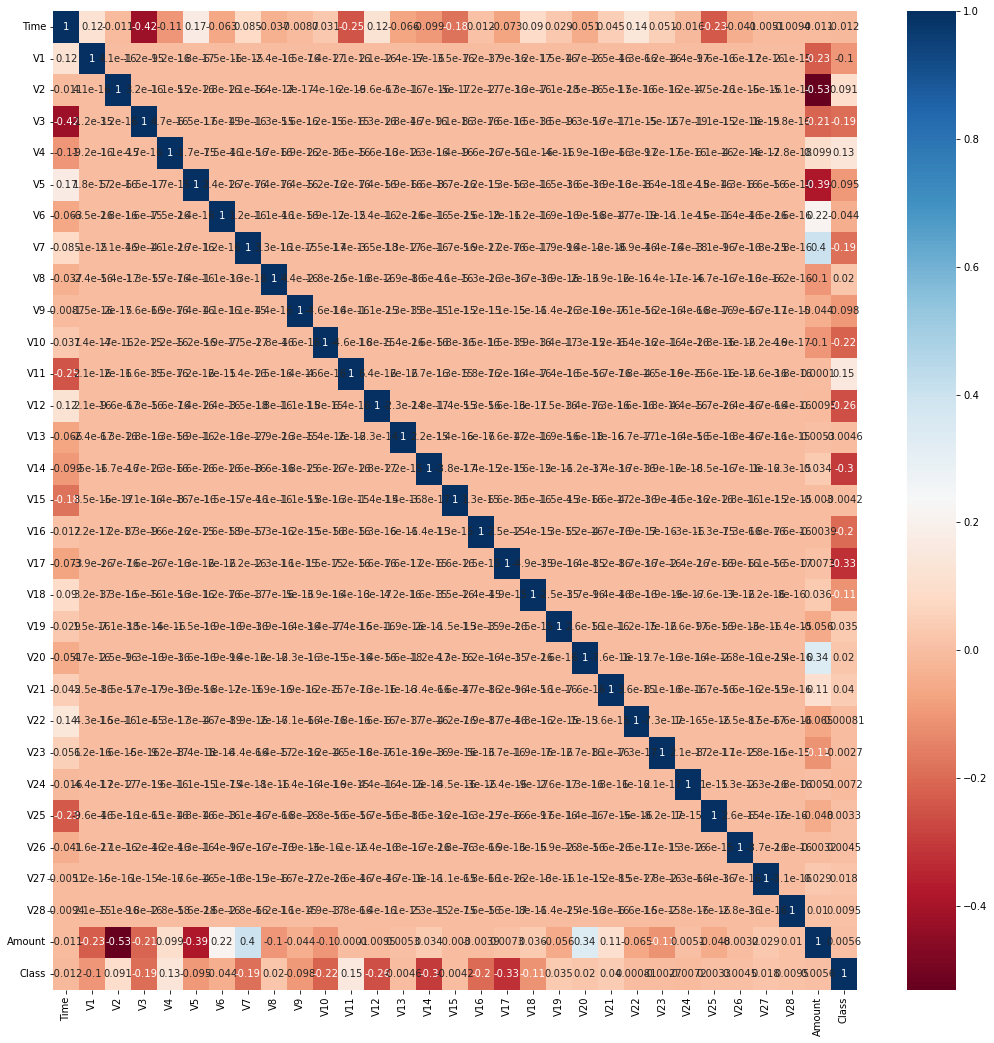

In [20]:
import seaborn as sns

plt.figure(figsize=(18, 18))
sns.heatmap(card_df.corr(), cmap='RdBu', annot=True)

Class와 음의 상관관계가 가장 높은 피처는 V14(-0.3)와 V17(-0.33), 이중 V14에 대해서만 이상치를 찾아 제거

**Dataframe에서 outlier에 해당하는 데이터를 필터링하기 위한 함수 생성. outlier 레코드의 index를 반환**

In [21]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [22]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


**로그 변환 후 V14 피처의 이상치 데이터를 삭제한 뒤 모델들을 재 학습/예측/평가**

In [23]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288, F1: 0.8897, AUC:0.9780


- 로지스틱 회귀 모델의 경우 재현율이 0.6017->0.6712로 성능 개선
- LightGBM 모델의 경우 재현율이 0.7635->0.8288로 성능 개선

# 4. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [26]:
# imbalanced-learn 설치 : 프롬포트(관리자권한) -> conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
# fit_sample -> fit_resample
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


SMOTE 적용 전 199,362건이 적용 후 2배에 가까운 398,040건으로 증가  
레이블 값이 0과 1의 분포가 동일하게 199020개로 생성

**로지스틱 회귀로 학습/예측/평가**

In [28]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값을 SMOTE 증식된 X_train_over와 y_train_over로 변경
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9737


로지스틱 회귀 모델의 경우
- 재현율이 0.6712->0.9247로 크게 증가
- 정밀도가 0.8750->0.0542로 크게 저하  

어떠한 문제가 있는지 임곗값에 따른 정밀도와 재현율 곡선으로 확인

**Precision-Recall 곡선 시각화**

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

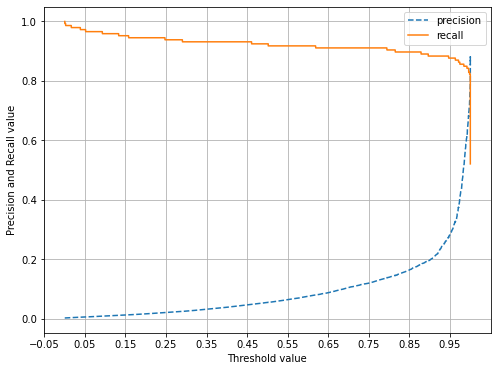

In [30]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

- 0.99 이하에서 재현율이 매우 좋고, 정밀도가 극단적으로 낮음
- 0.99 이상에서 반대로 재현율이 매우 낮고, 정밀도가 높음

임계깞을 조정하더라도 민감도가 너무 심해 올바른 재현율/정밀도 성능 얻을 수 없음

**LightGBM 모델 적용**

In [31]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, F1: 0.8794, AUC:0.9814


LightGBM 모델의 경우
- 재현율이 0.8288->0.8493로 증가
- 정밀도가 0.9603->0.9118로 저하  

일반적으로 SMOTE를 적용시 재현율은 증가하지만 정밀도는 감소한다